In [321]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json as js

In [322]:
oscar_df = pd.read_csv('the_oscar_award.csv')
metadata_df = pd.read_csv('movies_metadata.csv')

C:\Users\dalma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Oscar dataframe

In [323]:
oscar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10395 entries, 0 to 10394
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   year_film      10395 non-null  int64 
 1   year_ceremony  10395 non-null  int64 
 2   ceremony       10395 non-null  int64 
 3   category       10395 non-null  object
 4   name           10395 non-null  object
 5   film           10091 non-null  object
 6   winner         10395 non-null  bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 497.5+ KB


As per Academy Awards rules, movies nominated in a given year have to be exhibited between March and December of the previous year, so the year_film and year_ceremony columns are redundant, as for every datapoint it should be:
year_film = year_ceremony - 1
We check that this is the case. 

In [324]:
mask = oscar_df.year_film == (oscar_df.year_ceremony-1)
oscar_df[~mask]

,year_film,year_ceremony,ceremony,category,name,film,winner


The same argument of redundancy applies to the ceremony column. We drop these columns, keeping only year_film.

In [325]:
oscar_df = oscar_df.drop(['year_ceremony','ceremony'], axis=1)

We see that some datapoints have null values in the 'film' column. We explore this data to find out in what categories this is happening

In [326]:
oscar_df[oscar_df.film.isnull()].category.unique()

array(['ENGINEERING EFFECTS', 'WRITING (Title Writing)', 'SPECIAL AWARD',
       'SOUND RECORDING', 'ASSISTANT DIRECTOR',
       'IRVING G. THALBERG MEMORIAL AWARD',
       'SPECIAL FOREIGN LANGUAGE FILM AWARD',
       'HONORARY FOREIGN LANGUAGE FILM AWARD', 'HONORARY AWARD',
       'JEAN HERSHOLT HUMANITARIAN AWARD', 'SPECIAL ACHIEVEMENT AWARD'],
      dtype=object)

Some of these categories regard special honorary awards which are not necessarily related to a film: we are going to ignore these rows.

In [327]:
mask = (oscar_df.category == 'HONORARY AWARD') | \
       (oscar_df.category == 'SPECIAL AWARD') | \
       (oscar_df.category == 'IRVING G. THALBERG MEMORIAL AWARD') | \
       (oscar_df.category == 'JEAN HERSHOLT HUMANITARIAN AWARD') | \
       (oscar_df.category == 'SPECIAL ACHIEVEMENT AWARD') | \
       (oscar_df.category == 'HONORARY FOREIGN LANGUAGE FILM AWARD') | \
       (oscar_df.category == 'SPECIAL FOREIGN LANGUAGE FILM AWARD')

oscar_df = oscar_df[~mask]
oscar_df[oscar_df.film.isnull()].head()

,year_film,category,name,film,winner
16,1927,ENGINEERING EFFECTS,Ralph Hammeras,NaN,False
18,1927,ENGINEERING EFFECTS,Nugent Slaughter,NaN,False
31,1927,WRITING (Title Writing),Joseph Farnham,NaN,True
32,1927,WRITING (Title Writing),"George Marion, Jr.",NaN,False
145,1930,SOUND RECORDING,Samuel Goldwyn - United Artists Studio Sound D...,NaN,False


As to the other 30 rows, by checking manually, we can see that the data we are looking for is also missing on the official Oscars website: it is possible, for example, that the people nominated for these categories would work on different films in the same year.
For this reason we are going to drop these rows.

In [328]:
oscar_df = oscar_df.dropna(subset=['film'])
oscar_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10091 entries, 0 to 10390
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   year_film  10091 non-null  int64 
 1   category   10091 non-null  object
 2   name       10091 non-null  object
 3   film       10091 non-null  object
 4   winner     10091 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 404.0+ KB


The analysis we are going to perform is focused on the films. For this reason we are going to drop the name and category columns and group by the data based on the film, creating two columns counting the number of nomination and the number of wins for each film.

In [329]:
oscar_df.drop(['category','name'],axis=1)
oscar_df['nominations'] = 1
oscar_df['winner'] = oscar_df['winner'].apply(lambda x:int(x))
oscar_df['identifier'] = [str(oscar_df.year_film.iloc[i]) + oscar_df.film.iloc[i] for i in range(len(oscar_df.film))]

#we need to groupby the oscar_df for the different films, specifying also the year to distinguish films with the same title
#nominated in different years. To do this we create an identifier column that is than re-divided into the two initial columns.

oscar_df = oscar_df.groupby('identifier').sum()
oscar_df['film'] = [oscar_df.index[i][4:] for i in range(len(oscar_df.year_film))]
oscar_df['year_film'] = [int(oscar_df.index[i][0:4]) for i in range(len(oscar_df.year_film))]
oscar_df = oscar_df.set_index(pd.Series(range(len(oscar_df.film))))

After this changes in the dataset we end up with 4934 different films: the features are the film title, the year of publishing, the total number of nominations and the total number of awards won.

In [330]:
oscar_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4934 entries, 0 to 4933
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   year_film    4934 non-null   int64 
 1   winner       4934 non-null   int64 
 2   nominations  4934 non-null   int64 
 3   film         4934 non-null   object
dtypes: int64(3), object(1)
memory usage: 192.7+ KB


In [331]:
oscar_df.describe()

,year_film,winner,nominations
count,4934.000000,4934.000000,4934.000000
mean,1974.010742,0.421362,2.045197
std,26.280313,1.001822,2.098474
min,1927.000000,0.000000,1.000000
25%,1950.000000,0.000000,1.000000
50%,1973.000000,0.000000,1.000000
75%,1997.000000,1.000000,2.000000
max,2019.000000,11.000000,14.000000


## Metadata dataframe

In [332]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

#### Dropping columns

We now go on with the data exploration and cleaning of the Metadata dataset. As we can see the dataset has 23 columns, many of which useless for the scope of this project:
- 'belongs to collection': describes whether or not a film belongs in one of the listed collections
- 'homepage': a link to the films website
- 'id' and 'imdb_id': a numerical identifier of the film in the database
- 'overview': a summarized plot of the movie
- 'tagline': a sentence the film was advertised with
- 'poster_path': the name of a file containing the poster for the film
- 'original_title': the title in the original language (since in the oscar dataset all titles are in english, this is useless)

On the other hand, 'video' is a boolean value that distinguishes films from other types of video content: in this project we are only interested in studying data related to films, so we'll drop rows having video value 1 and we'll drop the column.
We also checked that the vast majority of datapoints in the dataset have False as value in this column. 

We'll do the same thing for the 'status' column, which identifies whether films have been released or not: films that are not released aren't eligible for an Oscar nomination. Once again, dropping these rows doesn't cause a big loss in the number of data points.

Finally, the 'adult' column only has a few datapoints with True value, so the column doesn't carry much information, it will be dropped.

In [333]:
metadata_df.status.value_counts()

Released           45014
Rumored              230
Post Production       98
In Production         20
Planned               15
Canceled               2
Name: status, dtype: int64

In [334]:
metadata_df.video.value_counts()

False    45367
True        93
Name: video, dtype: int64

In [335]:
metadata_df.adult.value_counts()

False                                                                                                                             45454
True                                                                                                                                  9
 - Written by Ørnås                                                                                                                   1
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
Name: adult, dtype: int64

In [336]:
metadata_df = metadata_df.drop(['adult','belongs_to_collection','homepage','id','imdb_id','overview','tagline','poster_path','original_title'], axis=1)
metadata_df = metadata_df[metadata_df.video == False]
metadata_df = metadata_df[metadata_df.status == 'Released']
metadata_df = metadata_df.drop(['video','status'], axis=1)

#### Revenue and budget

As to the budget and revenue columns, we can see only a small portion of the films in the dataset have non-zero values. The information provided by these features could be useful to highlight a difference between movies that have been nominated and films that haven't: for this analysis we will ignore the zero values.

In [337]:
metadata_df.budget = metadata_df.budget.apply(lambda x:float(x)) #we transform the type to float

print("Non-zero budget values: ", sum(metadata_df.budget>0))
print("Non-zero revenue values: ", sum(metadata_df.revenue>0))

Non-zero budget values:  8860
Non-zero revenue values:  7395


#### Popularity, vote average and vote count

count    44921.000000
mean         5.625451
std          1.912502
min          0.000000
25%          5.000000
50%          6.000000
75%          6.800000
max         10.000000
Name: vote_average, dtype: float64

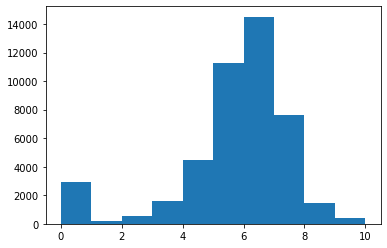

In [338]:
plt.hist(metadata_df.vote_average)
metadata_df.vote_average.describe()

count    44921.000000
mean       111.103560
std        494.117134
min          0.000000
25%          3.000000
50%         10.000000
75%         35.000000
max      14075.000000
Name: vote_count, dtype: float64

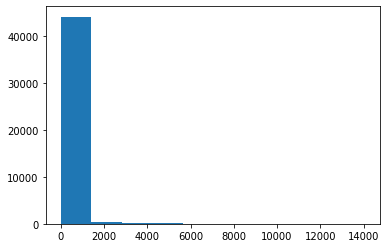

In [339]:
plt.hist(metadata_df.vote_count)
metadata_df.vote_count.describe()

As we can see from the histogram, the vast majority of films have a vote count between 0 and 1000, but the highest value in the column is 14075, associated with the film Inception.

In [340]:
metadata_df[metadata_df.vote_count == 14075]

,budget,genres,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count
15480,160000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",en,29.108149,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2010-07-14,825532764.0,148.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Inception,8.1,14075.0


count    44921.000000
mean         2.943406
std          6.028436
min          0.000000
25%          0.392813
50%          1.138586
75%          3.740902
max        547.488298
Name: popularity, dtype: float64


,budget,genres,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count
30700,74000000.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",en,547.488298,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'US', 'name': 'United States o...",2015-06-17,1.156731e+09,91.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Minions,6.4,4729.0


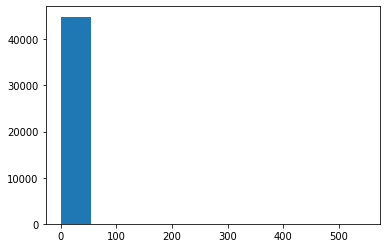

In [341]:
metadata_df.popularity = metadata_df.popularity.apply(lambda x:float(x))
plt.hist(metadata_df.popularity)
print(metadata_df.popularity.describe())
metadata_df[metadata_df.popularity == metadata_df.popularity.max()]

The value of popularity is not defined in the description of the dataset on Kaggle, so its characteristics are not really clear. It's a positive float value and almost all movies have a popularity value less than 10, but the maximum value is reached by the movie Minions at over 547.

All the features in this section (vote count, vote average and popularity) are values that can be changed after the nomination of a movie and for this reason, could give an unfair advantage to a model trying to predict nominations.

#### Runtime

We now consider the runtime column. We can see from the data from the "describe" function that 75% of the films are 107 minutes long, but the maximum value for runtime is 1256. The column also has some missing values.
We decide to drop the rows with runtime higher than 210, as this is around the maximum lenght for any feature film and the vast majority of our data is in this interval. We replace the null values and the zeros with the mean of the column as it is a good indicator of what approximately could be the runtime of these movies.

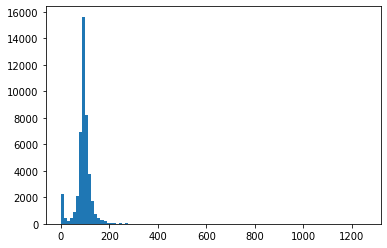

In [342]:
plt.hist(metadata_df.runtime,100)
plt.show()

285


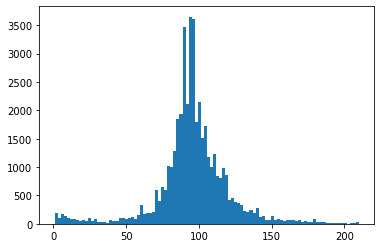

In [343]:
print(len(metadata_df[metadata_df.runtime>210].runtime))
metadata_df = metadata_df[metadata_df.runtime<=210]
runtime_mean = metadata_df[metadata_df.runtime>0].runtime.mean()
metadata_df.runtime = metadata_df.runtime.fillna(runtime_mean)
metadata_df.runtime = metadata_df.runtime.replace(0,runtime_mean)
plt.hist(metadata_df.runtime,100)
plt.show()

#### Release date

We see that 62 datapoints have null values in the release date column. As this is just a small number of datapoints and the release date couldn't be retrieved in any way other than through manual checking, we are going to drop this rows.

In [344]:
mask = metadata_df.release_date.isna()
metadata_df = metadata_df[~mask]

To better analyse the information given by the release date of a film, we extract from the data in the column (which is in the form yyyy-mm-dd), the release year and the day of the year going from 1 to 365.

In [345]:
def convert_date(date): #function to convert a list [month,day], into the numbered day of the year
    year = int(date[0:4])
    day = [int(date[5:7]),int(date[8:10])]
    month_days=[0,31,59,90,120,151,181,212,243,273,304,334]
    return [year,day[1]+month_days[day[0]-1]]

In [346]:
metadata_df['year'] = metadata_df.release_date
metadata_df['day'] = metadata_df.release_date

metadata_df['year'] = metadata_df['year'].apply(lambda x:convert_date(x)[0])
metadata_df['day'] = metadata_df['day'].apply(lambda x:convert_date(x)[1])

metadata_df = metadata_df.drop(['release_date'], axis=1)

We observe that a disproportionate number of movies has 1 as its release day. This is probably because, when the actual release date was not clear, the first of january of that year was inputted into the df.

In [347]:
metadata_df.day.value_counts()

1      3027
274     341
121     266
60      261
152     258
       ... 
186      57
8        55
5        52
4        50
3        42
Name: day, Length: 365, dtype: int64

The first Academy Award Ceremony was celebrated in 1928, so we can drop any film released before 1927. The metadata dataset was created in 2016, so we are going to drop from both datasets the movies published after that year.

In [348]:
metadata_df = metadata_df[metadata_df.year >= 1927]
metadata_df = metadata_df[metadata_df.year < 2017]
oscar_df = oscar_df[oscar_df.year_film < 2017]

#### Json formatted columns

We now go on to change the format of the columns that are now formatted with JSON (JavaScript Object Notation): genres, production companies, production countries and spoken languages.

In [349]:
n = len(metadata_df.genres)
numero = []
different_genres = []
film_genre = [[] for i in range(n)]

for i in range(n):
    #the js.loads function takes a string formatted in JSON as returns a list of dictionaries
    list_dict = js.loads(metadata_df.genres.iloc[i].replace("'",'"')) # the difference between ' and " generated errors
    numero.append(len(list_dict))
    for dict in list_dict:
        film_genre[i].append(dict['name'])
        if dict['name'] not in different_genres: 
            different_genres.append(dict['name'])
    
metadata_df['genres'] = film_genre

print(max(numero))
print(len(different_genres))
print(different_genres)

8
20
['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music', 'Documentary', 'Western', 'TV Movie']


We find that the maximum number of genres for a single film in this dataset is 8 and that are a total of 20 possible different genres. We have also replaced the genres column with lists of genres instead of JSON dictionaries.
To mantain this information and to be able to analyse it better we create 20 new columns of boolean values, one for each possible genre.
After this we can also drop the previous genre column.

In [350]:
for genre in different_genres:
    metadata_df['genre ' + genre] = 0
    for i in range(n):
        if genre in metadata_df.genres.iloc[i]:
            metadata_df['genre ' + genre].iloc[i] = 1

metadata_df = metadata_df.drop('genres', axis=1)

C:\Users\dalma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [351]:
n = len(metadata_df.production_companies)
numero = []
different_productions = []
count = []
film_production_company = [[] for i in range(n)]

for i in range(n):
    try:
        list_dict = js.loads(metadata_df.production_companies.iloc[i].replace("'",'"'))
        numero.append(len(list_dict))
        for dict in list_dict:
            film_production_company[i].append(dict['name'])
            count.append(dict['name'])
            if dict['name'] not in different_productions: 
                different_productions.append(dict['name'])
    except: pass #some datapoints have problematic encodings for the production companies that raise errors


metadata_df['production_companies'] = film_production_company
count = pd.Series(count)
print(count.value_counts())
print(max(numero))
print(len(different_productions))
sum(count.value_counts()>500)

Warner Bros.                              1226
Metro-Goldwyn-Mayer (MGM)                 1021
Paramount Pictures                         976
Twentieth Century Fox Film Corporation     815
Universal Pictures                         810
                                          ... 
Golden Tripod Film Co., Hong Kong            1
I Lied About Everything Picture              1
How To Productions                           1
WV Films LLC                                 1
Pirie Productions                            1
Length: 22298, dtype: int64
26
22298


5

We have found that in the dataset are presented more than 22 thousand different production companies and as many as 26 for a single film!
However, only 5 have produced more than 500 films each: to retain some information from this column we are going to create 5 boolean columns, one for each of the largest producing companies and then remove the old producing companies column.

In [352]:
metadata_df['prod_warner'] = 0
metadata_df['prod_mgm'] = 0
metadata_df['prod_paramount'] = 0
metadata_df['prod_20centuryfox'] = 0
metadata_df['prod_universal'] = 0

for i in range(n):
    if "Warner Bros." in metadata_df.production_companies.iloc[i]: metadata_df.prod_warner.iloc[i] = 1
    if "Metro-Goldwyn-Mayer (MGM)" in metadata_df.production_companies.iloc[i]: metadata_df.prod_mgm.iloc[i] = 1
    if "Paramount Pictures" in metadata_df.production_companies.iloc[i]: metadata_df.prod_paramount.iloc[i] = 1
    if "Twentieth Century Fox Film Corporation" in metadata_df.production_companies.iloc[i]: metadata_df.prod_20centuryfox.iloc[i] = 1
    if "Universal Pictures" in metadata_df.production_companies.iloc[i]: metadata_df.prod_universal.iloc[i] = 1


metadata_df = metadata_df.drop('production_companies', axis=1)

In [353]:
n = len(metadata_df.production_countries)
numero = []
different_countries = []
count = []
film_production_country = [[] for i in range(n)]

for i in range(n):
    try:
        list_dict = js.loads(metadata_df.production_countries.iloc[i].replace("'",'"')) # the difference between ' and " generated errors
        numero.append(len(list_dict))
        for dict in list_dict:
            film_production_country[i].append(dict['name'])
            count.append(dict['name'])
            if dict['name'] not in different_countries: 
                different_countries.append(dict['name'])
    except: pass

metadata_df['production_countries'] = film_production_country
count = pd.Series(count)
print(count.value_counts())
print(max(numero))
print(len(different_countries))
sum(count.value_counts()>1000)

United States of America                20311
United Kingdom                           3961
France                                   3725
Germany                                  2104
Italy                                    2089
                                        ...  
Kuwait                                      1
Martinique                                  1
United States Minor Outlying Islands        1
Cayman Islands                              1
Guinea                                      1
Length: 158, dtype: int64
25
158


7

We can see that 158 different possible producing countries exist in the dataframe and that a single film can have up to 25 different producing countries. But at the same time, some countries produced a very large number of films compared to the rest: as we did before we are going to create 7 boolean columns, one for each of the countries that have produced more than 1000 movies in this dataset.

In [354]:
metadata_df['country_us'] = 0
metadata_df['country_uk'] = 0
metadata_df['country_fr'] = 0
metadata_df['country_ge'] = 0
metadata_df['country_it'] = 0
metadata_df['country_ca'] = 0
metadata_df['country_ja'] = 0

for i in range(n):
    if "United States of America" in metadata_df.production_countries.iloc[i]: metadata_df.country_us.iloc[i] = 1
    if "United Kingdom" in metadata_df.production_countries.iloc[i]: metadata_df.country_uk.iloc[i] = 1
    if "France" in metadata_df.production_countries.iloc[i]: metadata_df.country_fr.iloc[i] = 1
    if "Germany" in metadata_df.production_countries.iloc[i]: metadata_df.country_ge.iloc[i] = 1
    if "Italy" in metadata_df.production_countries.iloc[i]: metadata_df.country_it.iloc[i] = 1
    if "Canada" in metadata_df.production_countries.iloc[i]: metadata_df.country_ca.iloc[i] = 1
    if "Japan" in metadata_df.production_countries.iloc[i]: metadata_df.country_ja.iloc[i] = 1


metadata_df = metadata_df.drop('production_countries', axis=1)

The only column left with Json values is the spoken_languages column: given that some information about the language of the film is already given by the original_language column, we are eventually going to discard this feature. As we can see that the original_language column has some null values, we are going to substitute the first spoken language as the original language to fill the NAs.

In [355]:
for i in metadata_df[metadata_df.original_language.isna()].index:
    metadata_df['original_language'].loc[i] = js.loads(metadata_df.spoken_languages.loc[i].replace("'",'"'))[0]['iso_639_1']

metadata_df = metadata_df.drop('spoken_languages', axis=1)
metadata_df.original_language.value_counts()[0:10]

en    30832
fr     2272
it     1437
ja     1328
de      972
es      943
ru      747
hi      485
ko      436
zh      395
Name: original_language, dtype: int64

We can see that the original_language column has 7 languages with more than 500 films. We are once again going to create 7 columns of boolean values to transform this categorical data into numerical data.

In [356]:
metadata_df['language_en'] = 0
metadata_df['language_fr'] = 0
metadata_df['language_it'] = 0
metadata_df['language_ja'] = 0
metadata_df['language_de'] = 0
metadata_df['language_es'] = 0
metadata_df['language_ru'] = 0

for i in range(n):
    if metadata_df.original_language.iloc[i] == 'en': metadata_df.language_en.iloc[i] = 1
    if metadata_df.original_language.iloc[i] == 'fr': metadata_df.language_fr.iloc[i] = 1
    if metadata_df.original_language.iloc[i] == 'it': metadata_df.language_it.iloc[i] = 1
    if metadata_df.original_language.iloc[i] == 'ja': metadata_df.language_ja.iloc[i] = 1
    if metadata_df.original_language.iloc[i] == 'de': metadata_df.language_de.iloc[i] = 1
    if metadata_df.original_language.iloc[i] == 'es': metadata_df.language_es.iloc[i] = 1
    if metadata_df.original_language.iloc[i] == 'ru': metadata_df.language_ru.iloc[i] = 1


metadata_df = metadata_df.drop('original_language', axis=1)

In [357]:
metadata_df.head()

,budget,popularity,revenue,runtime,title,vote_average,vote_count,year,day,genre Animation,...,country_it,country_ca,country_ja,language_en,language_fr,language_it,language_ja,language_de,language_es,language_ru
0,30000000.0,21.946943,373554033.0,81.0,Toy Story,7.7,5415.0,1995,303,1,...,0,0,0,1,0,0,0,0,0,0
1,65000000.0,17.015539,262797249.0,104.0,Jumanji,6.9,2413.0,1995,349,0,...,0,0,0,1,0,0,0,0,0,0
2,0.0,11.712900,0.0,101.0,Grumpier Old Men,6.5,92.0,1995,356,0,...,0,0,0,1,0,0,0,0,0,0
3,16000000.0,3.859495,81452156.0,127.0,Waiting to Exhale,6.1,34.0,1995,356,0,...,0,0,0,1,0,0,0,0,0,0
4,0.0,8.387519,76578911.0,106.0,Father of the Bride Part II,5.7,173.0,1995,41,0,...,0,0,0,1,0,0,0,0,0,0


### Joining the two datasets

We have explored and cleaned the data from the two datasets, now we want to join them. We are going to join them on the film title and the release year. Before doing this we want to normalize the film titles to avoid problem related to special characters, ecc.

In [358]:
import unidecode
import re

def normalize(title):

    norm_title = title.lower() #remove capitalization
    norm_title = re.sub("[\(\[].*?[\)\]]", "", norm_title)
    norm_title = re.sub(r'[^\w\s]','', norm_title) #using the re library we remove all punctuation
    norm_title = norm_title.replace(' ','') #remove spaces
        
    norm_title = norm_title.replace('Ã¨','è')
    norm_title = norm_title.replace('Ã©','é')
    norm_title = norm_title.replace('Ã±','ñ')

    norm_title = unidecode.unidecode(norm_title) #this function associates any accented or 'strange' character to its closest approximation into ASCII characters
    
    return norm_title.strip() #this function removes all leading and trailing whitespaces

In [359]:
metadata_df['norm_title'] = metadata_df.title.apply(normalize)
oscar_df['norm_title'] = oscar_df.film.apply(normalize)
df = pd.merge(metadata_df, oscar_df,  how='left', left_on=['norm_title','year'], right_on = ['norm_title','year_film']) #merge using both the normalized title and the release year

In [360]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43248 entries, 0 to 43247
Data columns (total 53 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   budget                 43248 non-null  float64
 1   popularity             43248 non-null  float64
 2   revenue                43248 non-null  float64
 3   runtime                43248 non-null  float64
 4   title                  43248 non-null  object 
 5   vote_average           43248 non-null  float64
 6   vote_count             43248 non-null  float64
 7   year                   43248 non-null  int64  
 8   day                    43248 non-null  int64  
 9   genre Animation        43248 non-null  int64  
 10  genre Comedy           43248 non-null  int64  
 11  genre Family           43248 non-null  int64  
 12  genre Adventure        43248 non-null  int64  
 13  genre Fantasy          43248 non-null  int64  
 14  genre Romance          43248 non-null  int64  
 15  ge

Unfortunately, as we can see from the information about df, out of all 4770, only 2849 nominated movies were found in the metadata dataset. This could be due to problems in the titles of the films that we weren't able to solve through normalization and also because most of the movies in the metadata dataset are more recent, so the films nominated in the earlier Oscar years could be missing.

<function matplotlib.pyplot.show(close=None, block=None)>

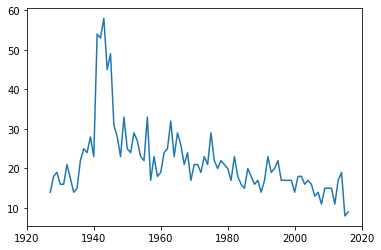

In [361]:
found_years = df[~df.film.isna()].year
not_found_years = oscar_df.year_film.value_counts() - found_years.value_counts()
plt.plot(not_found_years.index,not_found_years.values,20)
plt.xlim([1920, 2020])
plt.show

I fill the NA values in the complete df, drop the unnecessary columns and create two new columns that we'll use to analyse the data.

In [362]:
df.winner = df.winner.fillna(0)
df.nominations = df.nominations.fillna(0)
df = df.drop(['norm_title','year_film','film'], axis=1)

df['nominated_at_least_once'] = df.nominations>0
df['won_at_least_once'] = df.winner>0

df['nominated_at_least_once'].replace( { True:1, False:0}, inplace=True )
df['won_at_least_once'].replace( { True:1, False:0}, inplace=True )
df.popularity = df.popularity.apply(lambda x:float(x))

df.to_csv('model_df.csv', index=False)

In the last commented line we exported the final df in order to upload it to the streamlit file to develop the predictive model without having to wait for the preprocessing of the data.